<a href="https://colab.research.google.com/github/Darsangmdd/Onion-Price-prediction_ARIMA/blob/main/TSA_Onion_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***ONION PRICE PREDICTION WITH TIMES SERIES ANALYSIS AND FORECASTING USING AUTO REGRESSIVE INTEGRATED MOVING AVERAGE MODEL (ARIMA)***

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib
import seaborn as sns 

Using matplotlib backend: agg


In [2]:
data = pd.read_excel('MonthWiseMarketArrivals_Chennai.xlsx')

In [3]:
data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod
0,CHENNAI,January,2004,103400,798,1019,910
1,CHENNAI,February,2004,87800,776,969,873
2,CHENNAI,March,2004,102180,506,656,580
3,CHENNAI,April,2004,83300,448,599,527
4,CHENNAI,May,2004,84850,462,596,529


In [4]:
data.columns

Index(['market', 'month', 'year', 'quantity', 'priceMin', 'priceMax',
       'priceMod'],
      dtype='object')

In [5]:
data.drop(columns=['market','quantity', 'priceMin', 'priceMax'], inplace =True)

In [6]:
data.head()

,month,year,priceMod
0,January,2004,910
1,February,2004,873
2,March,2004,580
3,April,2004,527
4,May,2004,529


In [7]:
data.dtypes

month       object
year         int64
priceMod     int64
dtype: object

***MAKE A SEPARATE COLUMN FOR DATE AND MONTH COMBINED***

In [8]:
data['date'] =  data['month'] + '-' + data['year'].map(str)

In [9]:
data.dtypes

month       object
year         int64
priceMod     int64
date        object
dtype: object

In [10]:
data['date'] = pd.to_datetime(data['date'])

In [11]:
data.dtypes

month               object
year                 int64
priceMod             int64
date        datetime64[ns]
dtype: object

In [12]:
data = data[['priceMod','date']]

In [13]:
data.head()

,priceMod,date
0,910,2004-01-01
1,873,2004-02-01
2,580,2004-03-01
3,527,2004-04-01
4,529,2004-05-01


***CONVERT DATE TO INDEX***

In [14]:
data = data.set_index('date')
data.head()

,priceMod
date,
2004-01-01,910
2004-02-01,873
2004-03-01,580
2004-04-01,527
2004-05-01,529


***CONVERT DATAFRAMES TO SERIES***

In [15]:
data = data.squeeze()
type(data)

pandas.core.series.Series

***SPLITTING DATA INTO TRAINING AND VALIDATION DATA***

In [16]:
split_point = len(data) - 5
dataset, validation = data[0:split_point], data[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 204, Validation 5


***BUILDING A PERSISTENCE MODEL***

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [18]:
# evaluate a persistence model
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  yhat = history[-1]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=887.000, Expected=1038.000
>Predicted=1038.000, Expected=1143.000
>Predicted=1143.000, Expected=1123.000
>Predicted=1123.000, Expected=1269.000
>Predicted=1269.000, Expected=1921.000
>Predicted=1921.000, Expected=1910.000
>Predicted=1910.000, Expected=1964.000
>Predicted=1964.000, Expected=2033.000
>Predicted=2033.000, Expected=1518.000
>Predicted=1518.000, Expected=1410.000
>Predicted=1410.000, Expected=1431.000
>Predicted=1431.000, Expected=1850.000
>Predicted=1850.000, Expected=2756.000
>Predicted=2756.000, Expected=4530.000
>Predicted=4530.000, Expected=5217.000
>Predicted=5217.000, Expected=4676.000
>Predicted=4676.000, Expected=4705.000
>Predicted=4705.000, Expected=2609.000
>Predicted=2609.000, Expected=1477.000
>Predicted=1477.000, Expected=1300.000
>Predicted=1300.000, Expected=1288.000
>Predicted=1288.000, Expected=1320.000
>Predicted=1320.000, Expected=1640.000
>Predicted=1640.000, Expected=2288.000
>Predicted=2288.000, Expected=2981.000
>Predicted=2981.000, Expec

In [19]:
series.describe()

count     204.000000
mean     1621.764706
std      1236.655108
min       384.000000
25%       878.750000
50%      1263.000000
75%      1953.500000
max      9876.000000
Name: 1, dtype: float64

**PLOTTING THE DATASET**

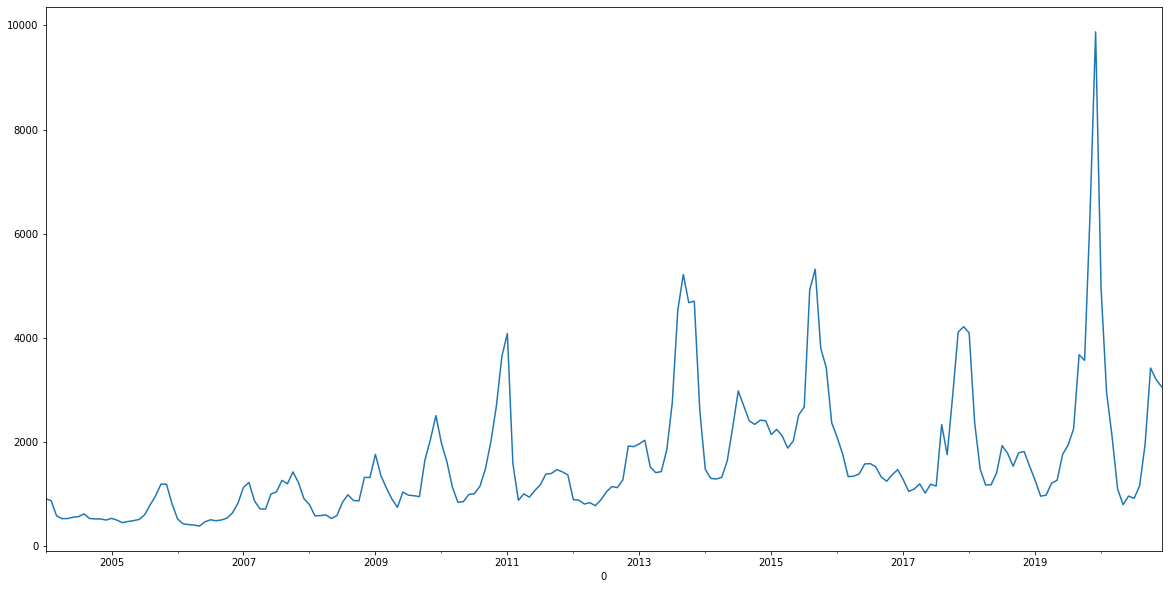

In [20]:
plt.figure(figsize=(20,10))
series.plot()

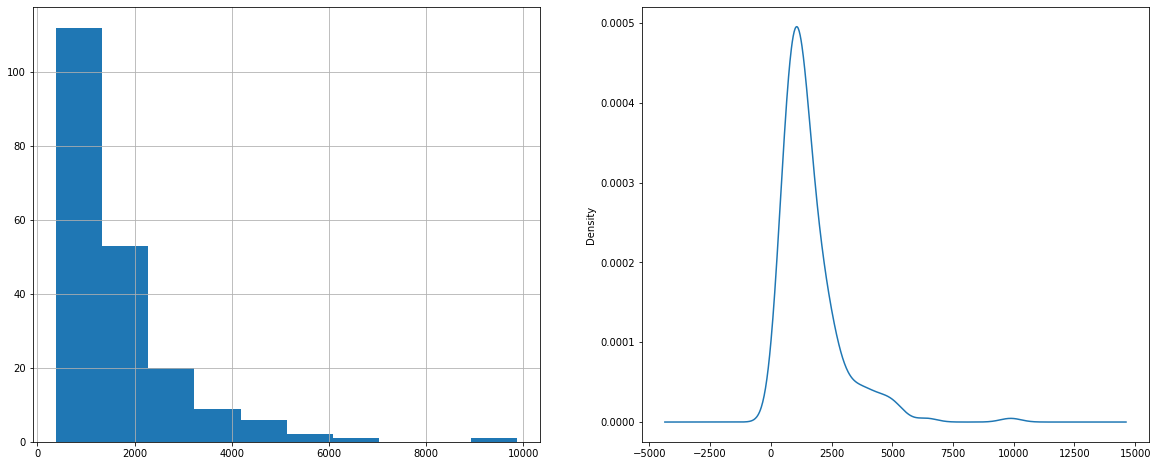

In [21]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
series.hist()
plt.subplot(1, 2, 2)
series.plot(kind='kde')

In [22]:
from pandas import Grouper

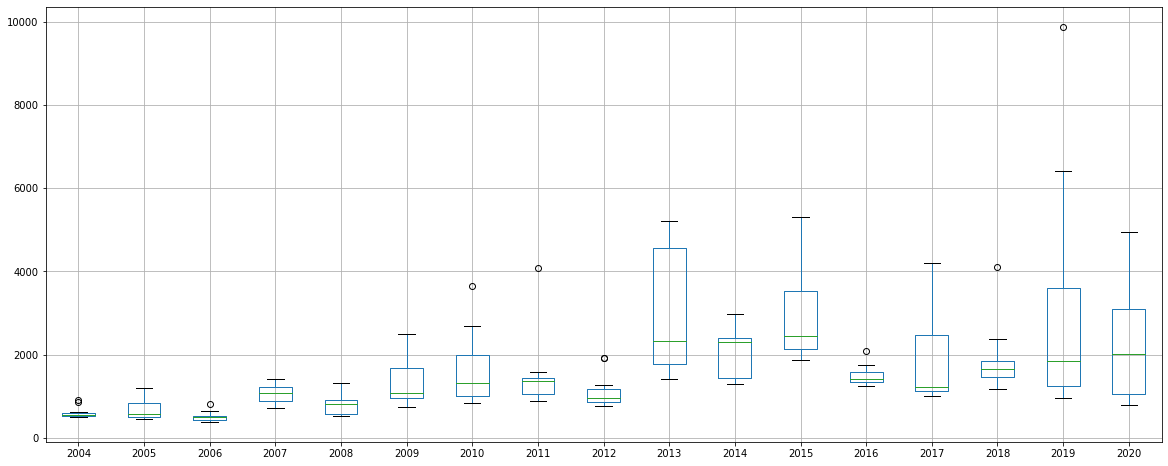

In [23]:
plt.figure(figsize=(20,8))
groups = series['2004':'2020'].groupby(Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group.values
years.boxplot()

**CREATING A DIFFERENCED TIME SERIES AND EVALUATING USING AUGMENTED DICKEY FULLER TEST**

In [24]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
# create a differenced time series
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return pd.Series(diff)

In [26]:
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.901252
p-value: 0.000000
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


***Augmented Dickey Fuller test statistic value is -7.90 which is lesser than the critical value at 1% (-3.465). Therefore, we reject the null hypothesis which states that the series is non-stationary. Hence, the series is stationary and thereby has no unit root. Moreover, we also get to know that the difference value (d) is 1. ***

**FINDING THE 'p' and 'q' VALUES USING AUTO CORRELATON AND PARTIAL AUTO CORRELATION**

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

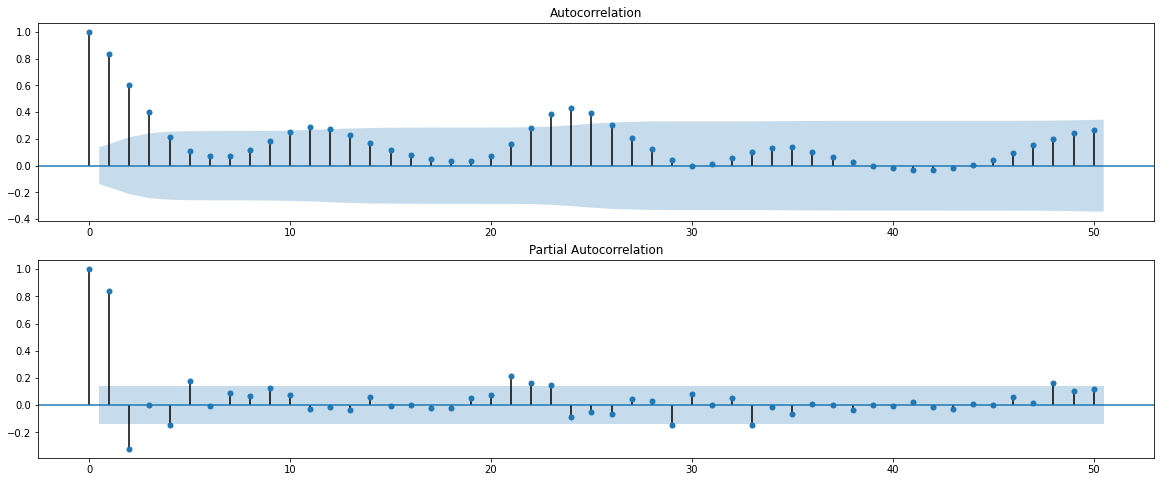

In [28]:
plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.show()

**CREATING AN ARIMA MODEL WITH (p,d,q) = (3,1,1) AS OBSERVED FROM THE CORRELATION PLOTS**

In [29]:
from statsmodels.tsa.arima_model import ARIMA
# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(3,1,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=1158.246, Expected=1038.000
>Predicted=1277.257, Expected=1143.000
>Predicted=1323.931, Expected=1123.000
>Predicted=1249.149, Expected=1269.000
>Predicted=1414.394, Expected=1921.000
>Predicted=2088.912, Expected=1910.000
>Predicted=1818.837, Expected=1964.000
>Predicted=1861.487, Expected=2033.000
>Predicted=1926.890, Expected=1518.000
>Predicted=1336.610, Expected=1410.000
>Predicted=1410.541, Expected=1431.000
>Predicted=1503.027, Expected=1850.000
>Predicted=1962.217, Expected=2756.000
>Predicted=2823.027, Expected=4530.000
>Predicted=4693.683, Expected=5217.000
>Predicted=4775.367, Expected=4676.000
>Predicted=3668.177, Expected=4705.000
>Predicted=4253.455, Expected=2609.000
>Predicted=1388.102, Expected=1477.000
>Predicted=767.650, Expected=1300.000
>Predicted=1345.205, Expected=1288.000
>Predicted=1521.363, Expected=1320.000
>Predicted=1578.716, Expected=1640.000
>Predicted=1949.187, Expected=2288.000
>Predicted=2604.928, Expected=2981.000
>Predicted=3164.812, Expec

**USING GRID SEARCH TO FIND OUT THE OPTIMAL ARIMA HYPERPARAMETERS**

In [30]:
# import warnings
# # evaluate an ARIMA model for a given order (p,d,q) and return RMSE
# def evaluate_arima_model(X, arima_order):
#   # prepare training dataset
#   X = X.astype('float32') 
#   train_size = int(len(X) * 0.50)
#   train, test = X[0:train_size], X[train_size:]
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(test)):
#     model = ARIMA(history, order=arima_order)
#     model_fit = model.fit(disp=0)
#     yhat = model_fit.forecast()[0]
#     predictions.append(yhat)
#     history.append(test[t])
#   # calculate out of sample error
#   rmse = sqrt(mean_squared_error(test, predictions))
#   return rmse  

In [31]:
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#   dataset = dataset.astype('float32')
#   best_score, best_cfg = float("inf"), None
#   for p in p_values:
#     for d in d_values:
#       for q in q_values:
#         order = (p,d,q)
#         try:
#           rmse = evaluate_arima_model(dataset, order)
#           if rmse < best_score:
#             best_score, best_cfg = rmse, order
#           print('ARIMA%s RMSE=%.3f' % (order,rmse))
#         except:
#           continue
#   print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [32]:
# # load dataset
# series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# # evaluate parameters
# p_values = range(0,25)
# d_values = range(0, 2)
# q_values = range(0, 2)
# warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

***(p,d,q) = (4, 0, 1) gives the least Root Mean square error value, therefore, we will use this combination in our study moving forward!***

In [33]:
import warnings 
warnings.filterwarnings("ignore")

**REVIEWING RESIDUAL ERRORS**

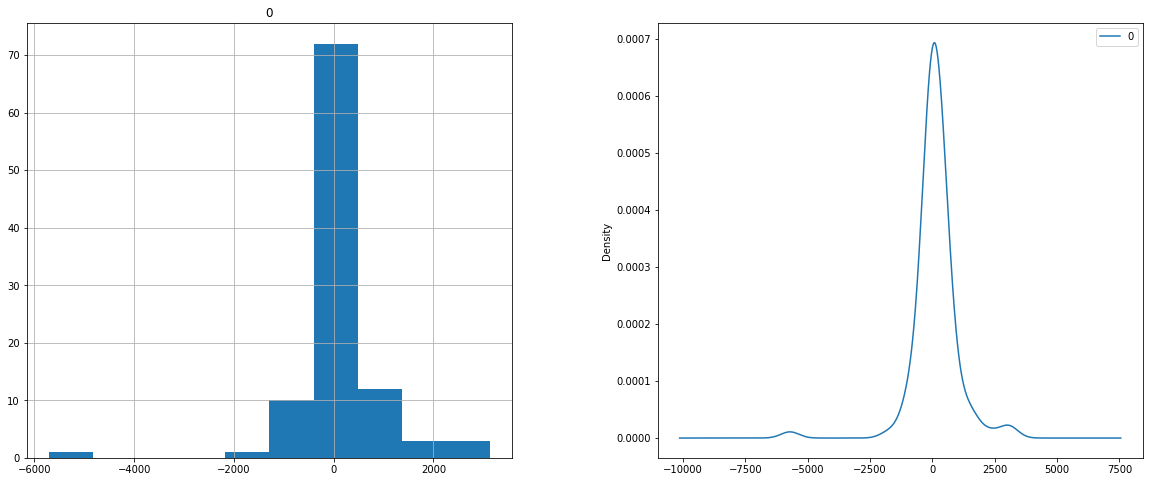

In [34]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # predict
  model = ARIMA(history, order=(4,0,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
plt.figure(figsize=(20,8))
plt.subplot(121)
residuals.hist(ax=plt.gca())
plt.subplot(122)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

**THE GRAPH SUGGESTS A GAUSSIAN-LIKE DISTRIBUTION AND THERE SEEMS TO BE MINIMAL BIAS AND HENCE, WE NEGLECT IT.**

**ACF AND PACT PLOTS OF RESIDUAL ERRORS**

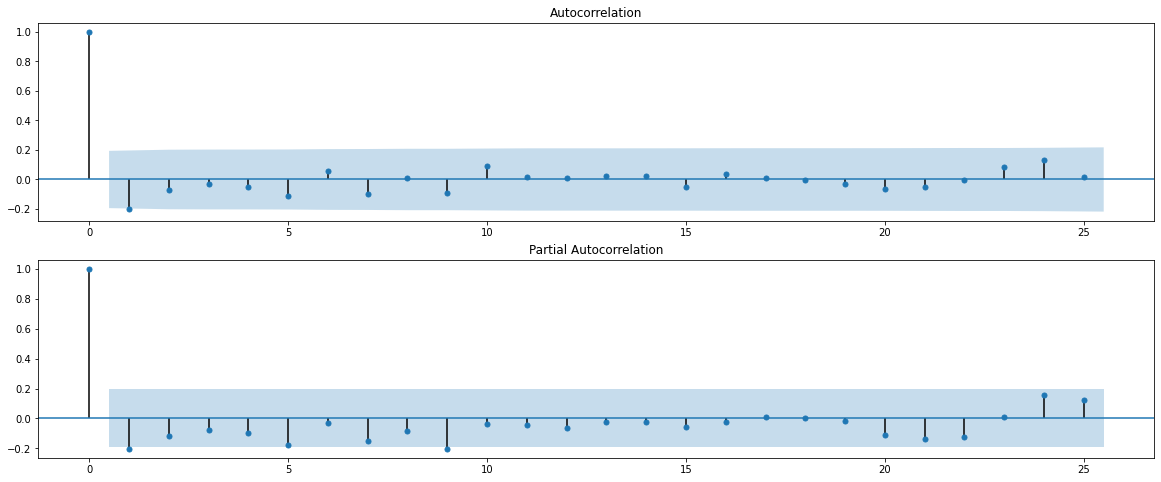

In [35]:
plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

**THE PLOT SUGGESTS THAT LITTLE AUTOCORRELATION IS PRESENT WHICH IMPLIES THAT THE ARIMA MODEL HAS CAPTURED THE EXISTING TIME SERIES TO A GREAT EXTENT.**

**TRANSFORMING THE DATASET USING BOX-COX TRANFORM**

In [36]:
from scipy.stats import boxcox
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)

Lambda: -0.211850


**PLOTTING THE TRANSFORMED TIME SERIES**

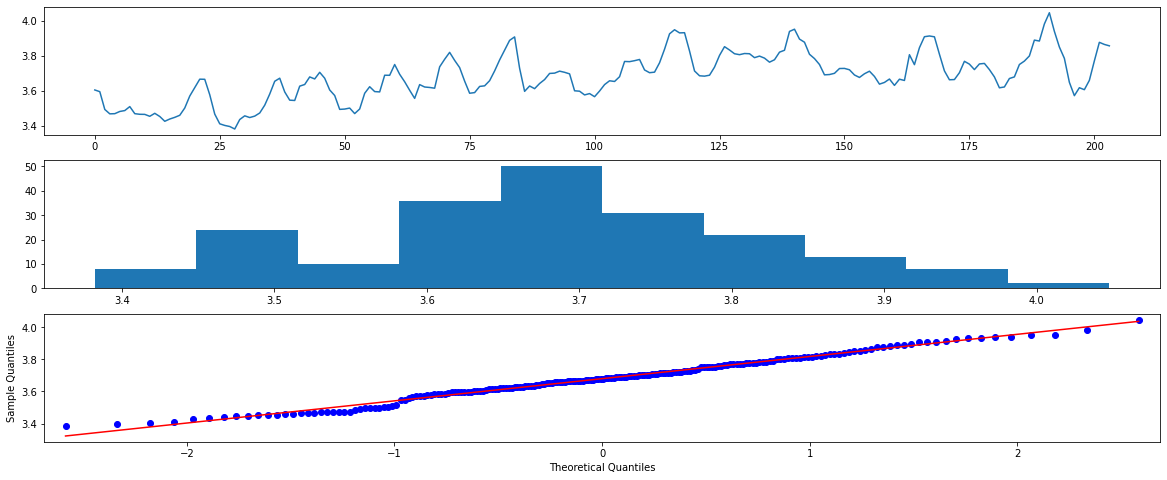

In [37]:
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(20,8))
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

1. **LARGE FLUCTUATION HAVE BEEN REMOVED FROM THE DATASET WHICH CAN BE SEEN IN THE LINE PLOT.**

2. **THE HISTOGRAM SHOWS A SOME WHAT UNIFORM GAUSSIAN DISTRIBUTION**

3. **THE QQ-PLOT IS REASONABLE AND SHOWS UNIFORM GAUSSIAN DISTRIBUTION**

In [38]:
from math import exp
from math import log

**RUNNING THE ARIMA MODEL ON THE BOXCOX TRANSFORMED DATASET**

In [39]:
# invert box-cox transform
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)
# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(4,0,1))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=960.730, Expected=1038.000
>Predicted=1094.655, Expected=1143.000
>Predicted=1178.443, Expected=1123.000
>Predicted=1121.137, Expected=1269.000
>Predicted=1352.507, Expected=1921.000
>Predicted=2139.143, Expected=1910.000
>Predicted=1806.916, Expected=1964.000
>Predicted=2018.875, Expected=2033.000
>Predicted=2096.922, Expected=1518.000
>Predicted=1374.034, Expected=1410.000
>Predicted=1506.049, Expected=1431.000
>Predicted=1490.696, Expected=1850.000
>Predicted=2001.244, Expected=2756.000
>Predicted=2996.562, Expected=4530.000
>Predicted=4827.733, Expected=5217.000
>Predicted=4933.085, Expected=4676.000
>Predicted=3782.897, Expected=4705.000
>Predicted=4331.849, Expected=2609.000
>Predicted=1241.623, Expected=1477.000
>Predicted=850.507, Expected=1300.000
>Predicted=926.934, Expected=1288.000
>Predicted=1393.716, Expected=1320.000
>Predicted=1193.545, Expected=1640.000
>Predicted=1842.739, Expected=2288.000
>Predicted=2291.253, Expected=2981.000
>Predicted=3149.728, Expecte

**FINALIZING AND SAVING THE MODEL**

In [44]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
#transform data
for i in range(len(X)):
   #transform
  transformed, lam = boxcox(X)
  if lam < -5:
    transformed, lam = history, 1
# fit model
model = ARIMA(transformed, order=(4,0,1))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

In [45]:
lam

1

**LOADING THE MODEL AND MAKING A SINGLE FORECAST**

In [46]:
from statsmodels.tsa.arima_model import ARIMAResults
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 2956.908


***If we peek inside validation.csv, we can see that the value on the first row for the next time period is 2976. The model got it somewhat correct.***

**VALIDATING THE MODEL BY FORECASTING THE DATA FOR THE NEXT 12 MONTHS AND COMPARING IT WITH validation.csv**

In [49]:
# load and prepare datasets
dataset = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True,
squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
  # transform
  transformed, lam = boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
  # predict
  model = ARIMA(transformed, order=(0,1,2))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2956.908, Expected=2976.000
>Predicted=2869.047, Expected=4211.000
>Predicted=4624.793, Expected=3300.000
>Predicted=2751.411, Expected=1100.000
>Predicted=978.790, Expected=1150.000
RMSE: 1123.632


**PLOTTING THE EXPECTED AND PREDICTED VALUES**

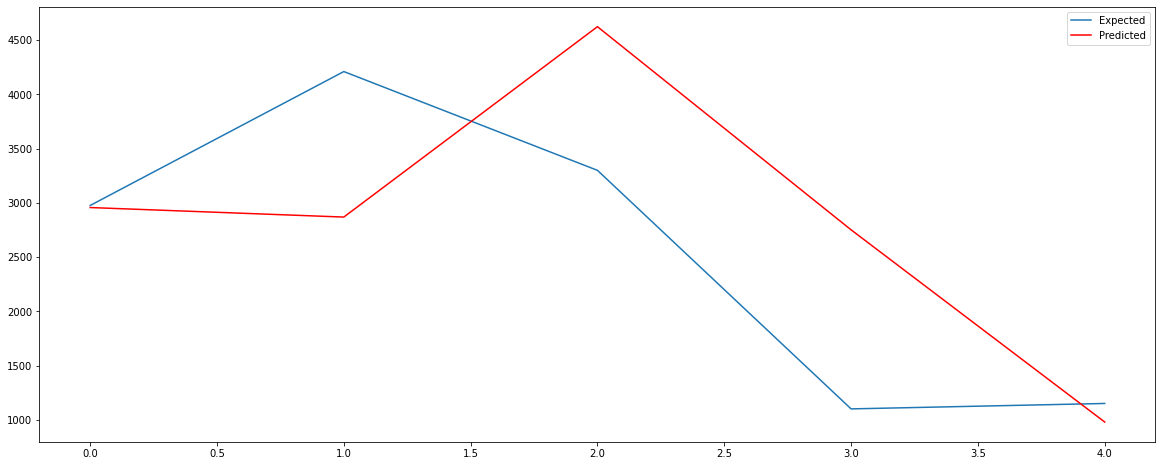

In [56]:
plt.figure(figsize=(20,8))
plt.plot(y)
plt.plot(predictions, color='red')
labels = ['Expected','Predicted']
plt.legend(labels)
plt.show()